In [1]:
%matplotlib inline

import torch
import numpy as np

import sys
sys.path.append('../ref_impls/SocialGAN-PyTorch')
sys.path.append('../code')

from stg_node import STGNode, convert_to_label_node
from utils import plot_utils
import os
import copy
import pickle
from collections import defaultdict, Counter

import random
import argparse
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from model.online_dyn_stg import SpatioTemporalGraphCVAEModel
from model.model_registrar import ModelRegistrar
from utils.scene_utils import create_batch_scene_graph

from attrdict import AttrDict

from sgan.data.loader import data_loader
from sgan.models import TrajectoryGenerator
from sgan.utils import relative_to_abs, get_dset_path

../code/utils/plot_utils.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/borisi/anaconda2/envs/dynstg/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/borisi/anaconda2/envs/dynstg/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/borisi/anaconda2/envs/dynstg/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/borisi/anaconda2/envs/dynstg/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/borisi/anaconda2/envs/dynstg/lib/python3.6/site-packages/ipykernel/kernelapp.py", 

In [2]:
hyperparams = {
    ### Training
    ## Batch Sizes
    'batch_size': 16,
    ## Learning Rate
    'learning_rate': 0.002,
    'min_learning_rate': 0.00001,
    'learning_decay_rate': 0.9999,
    ## Optimizer
    # 'optimizer': tf.train.AdamOptimizer,
    'optimizer_kwargs': {},
    'grad_clip': 1.0,

    ### Prediction
    'minimum_history_length': 8,    # 3.2 seconds
    'prediction_horizon': 12,       # 4.8 seconds (at least as far as the loss function is concerned)

    ### Variational Objective
    ## Objective Formulation
    'alpha': 1,
    'k': 3,              # number of samples from z during training
    'k_eval': 50,        # number of samples from z during evaluation
    'use_iwae': False,   # only matters if alpha = 1
    'kl_exact': True,    # relevant only if alpha = 1
    ## KL Annealing/Bounding
    'kl_min': 0.07,
    'kl_weight': 1.0,
    'kl_weight_start': 0.0001,
    'kl_decay_rate': 0.99995,
    'kl_crossover': 8000,
    'kl_sigmoid_divisor': 6,

    ### Network Parameters
    ## RNNs/Summarization
    'rnn_kwargs': {"dropout_keep_prob": 0.75},
    'MLP_dropout_keep_prob': 0.9,
    'rnn_io_dropout_keep_prob': 1.0,
    'enc_rnn_dim_multiple_inputs': 8,
    'enc_rnn_dim_edge': 8,
    'enc_rnn_dim_edge_influence': 8,
    'enc_rnn_dim_history': 32,
    'enc_rnn_dim_future': 32,
    'dec_rnn_dim': 128,
    'dec_GMM_proj_MLP_dims': None,
    'sample_model_during_dec': True,
    'dec_sample_model_prob_start': 0.0,
    'dec_sample_model_prob_final': 0.0,
    'dec_sample_model_prob_crossover': 20000,
    'dec_sample_model_prob_divisor': 6,
    ## q_z_xy (encoder)
    'q_z_xy_MLP_dims': None,
    ## p_z_x (encoder)
    'p_z_x_MLP_dims': 16,
    ## p_y_xz (decoder)
    'fuzz_factor': 0.05,
    'GMM_components': 16,
    'log_sigma_min': -10,
    'log_sigma_max': 10,
    'log_p_yt_xz_max': 50,

    ### Discrete Latent Variable
    'N': 2,
    'K': 5,
    ## Relaxed One-Hot Temperature Annealing
    'tau_init': 2.0,
    'tau_final': 0.001,
    'tau_decay_rate': 0.9999,
    ## Logit Clipping
    'use_z_logit_clipping': False,
    'z_logit_clip_start': 0.05,
    'z_logit_clip_final': 3.0,
    'z_logit_clip_crossover': 8000,
    'z_logit_clip_divisor': 6
}

parser = argparse.ArgumentParser()

parser.add_argument('--sgan_models_path', type=str, default='../ref_impls/SocialGAN-PyTorch/models/sgan-models')
parser.add_argument('--sgan_dset_type', default='test', type=str)


parser.add_argument("--dynamic_edges", help="whether to use dynamic edges or not, options are 'no' and 'yes'",
                    type=str, default='yes')
parser.add_argument("--edge_radius", help="the radius (in meters) within which two nodes will be connected by an edge",
                    type=float, default=1.5)
parser.add_argument("--edge_state_combine_method", help="the method to use for combining edges of the same type",
                    type=str, default=None)
parser.add_argument("--edge_influence_combine_method", help="the method to use for combining edge influences",
                    type=str, default=None)
parser.add_argument('--edge_addition_filter', nargs='+', help="what scaling to use for edges as they're created",
                    type=float, default=[0.25, 0.5, 0.75, 1.0]) # We automatically pad left with 0.0
parser.add_argument('--edge_removal_filter', nargs='+', help="what scaling to use for edges as they're removed",
                    type=float, default=[1.0, 0.0]) # We automatically pad right with 0.0
parser.add_argument('--incl_robot_node', help="whether to include a robot node in the graph or simply model all agents",
                    action='store_true')

parser.add_argument('--num_samples', help='how many times to sample from the model',
                    type=int, default=200)
parser.add_argument('--num_runs', help='how many scenes to predict per model evaluation',
                    type=int, default=10)

parser.add_argument('--device', help='what device to perform training on',
                    type=str, default='cpu')
parser.add_argument("--eval_device", help="what device to use during evaluation",
                    type=str, default='cpu')

parser.add_argument('--seed', help='manual seed to use, default is random',
                    type=int, default=123) # TODO: Make this None.
args = parser.parse_args(['--device', 'cpu'])


# 44.72 km/h = 12.42 m/s i.e. that's the max value that a velocity coordinate can be.
max_speed = 12.422222

if args.seed is not None:
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)


In [3]:
def get_sgan_data_format(our_inputs, data_id, t_predict, what_to_check='all'):
    ped_traj_list = list()
    seq_start_end = list()
    ped_traj_rel_list = list()
    gt_pos_list = list()
    data_ids = list()
    t_predicts = list()

    if what_to_check == 'curr':
        prev_tsteps = 1
        future_tsteps = 1
    elif what_to_check == 'all':
        prev_tsteps = 8
        future_tsteps = 12
    elif what_to_check == 'prev':
        prev_tsteps = 8
        future_tsteps = 1

    orig_len_ped_traj_list = len(ped_traj_list)
    for key, value in our_inputs.items():
        if isinstance(key, STGNode):
            to_check_pos = value[data_id,
                                 t_predict-prev_tsteps:t_predict+future_tsteps,
                                 :2].cpu().numpy()

            torch_pos = value[data_id, t_predict-8 : t_predict, :2]
            if np.all(to_check_pos):
                gt_pos = value[data_id, t_predict : t_predict + 12, :2]
                rel_traj = torch.zeros_like(torch_pos)
                rel_traj[1:] = torch_pos[1:] - torch_pos[:-1]

                ped_traj_list.append(torch_pos)
                ped_traj_rel_list.append(rel_traj)
                gt_pos_list.append(gt_pos)

    if orig_len_ped_traj_list < len(ped_traj_list):
        seq_start_end.append(torch.tensor([orig_len_ped_traj_list, len(ped_traj_list)]))
        data_ids.append(data_id)
        t_predicts.append(t_predict)

    obs_traj = torch.stack(ped_traj_list, dim=1)
    pred_traj_gt = torch.stack(gt_pos_list, dim=1)
    obs_traj_rel = torch.stack(ped_traj_rel_list, dim=1)
    seq_start_end = torch.stack(seq_start_end, dim=0)

    return (obs_traj, pred_traj_gt, obs_traj_rel,
            seq_start_end, data_ids, t_predicts)

In [4]:
def list_compare(a, b):
    return Counter(a) == Counter(b)


def sample_inputs_and_labels(data_dict, device, batch_size=None):
    if batch_size is not None:
        batch_sample = np.random.randint(low=0,
                                         high=data_dict['input_dict']['traj_lengths'].shape[0],
                                         size=batch_size)
        inputs = {k: torch.from_numpy(v[batch_sample]).float() for k, v in data_dict['input_dict'].items() if v.size > 0}
        labels = {k: torch.from_numpy(v[batch_sample]).float() for k, v in data_dict['labels'].items()}
    else:
        inputs = {k: torch.from_numpy(v).float() for k, v in data_dict['input_dict'].items() if v.size > 0}
        labels = {k: torch.from_numpy(v).float() for k, v in data_dict['labels'].items()}

    inputs = {k: v.to(device) for k, v in inputs.items()}
    labels = {k: v.to(device) for k, v in labels.items()}

    return inputs, labels

In [5]:
def get_our_model_dir(dataset_name):
    if dataset_name == 'eth':
        return 'models_03_Mar_2019_00_23_46'
    elif dataset_name == 'hotel':
        return 'models_03_Mar_2019_00_24_04'
    elif dataset_name == 'univ':
        return 'models_03_Mar_2019_13_48_01'
    elif dataset_name == 'zara1':
        return 'models_03_Mar_2019_13_48_21'
    elif dataset_name == 'zara2':
        return 'models_04_Mar_2019_00_49_31'
    else:
        return None


def get_model_hyperparams(args, dataset_name):
    if None not in [args.edge_state_combine_method, args.edge_influence_combine_method]:
        return {'edge_state_combine_method': args.edge_state_combine_method,
                'edge_influence_combine_method': args.edge_influence_combine_method,
                'best_iter': 1299}
    elif dataset_name == 'eth':
        return {'edge_state_combine_method': 'sum',
                'edge_influence_combine_method': 'attention',
                'best_iter': 1299}
    elif dataset_name == 'hotel':
        return {'edge_state_combine_method': 'sum',
                'edge_influence_combine_method': 'attention',
                'best_iter': 999}
    elif dataset_name == 'univ':
        return {'edge_state_combine_method': 'sum',
                'edge_influence_combine_method': 'attention',
                'best_iter': 1099}
    elif dataset_name == 'zara1':
        return {'edge_state_combine_method': 'sum',
                'edge_influence_combine_method': 'attention',
                'best_iter': 499}
    elif dataset_name == 'zara2':
        return {'edge_state_combine_method': 'sum',
                'edge_influence_combine_method': 'attention',
                'best_iter': 499}
    else:
        return None

In [6]:
def get_generator(checkpoint):
    args = AttrDict(checkpoint['args'])
    generator = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        embedding_dim=args.embedding_dim,
        encoder_h_dim=args.encoder_h_dim_g,
        decoder_h_dim=args.decoder_h_dim_g,
        mlp_dim=args.mlp_dim,
        num_layers=args.num_layers,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
        noise_mix_type=args.noise_mix_type,
        pooling_type=args.pooling_type,
        pool_every_timestep=args.pool_every_timestep,
        dropout=args.dropout,
        bottleneck_dim=args.bottleneck_dim,
        neighborhood_size=args.neighborhood_size,
        grid_size=args.grid_size,
        batch_norm=args.batch_norm)
    generator.load_state_dict(checkpoint['g_state'])
    # generator.cuda()
    generator.train()
    return generator

In [ ]:
import seaborn as sns
import pandas as pd

In [306]:
def plot_run_trajs(data_precondition, dataset_name,
                   our_preds_most_likely_list, our_preds_list,
                   sgan_preds_list, sgan_gt_list, eval_inputs, eval_data_dict,
                   data_ids, t_predicts, random_scene_idxs, num_runs,
                   specific_agent=None, save_at=None, calc_vels=False):
    eval_dt = eval_data_dict['dt']

    velocity_mags = list()
    
    for run in range(num_runs):
        plt.close('all')
        fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
        ax.set_xlabel(r'$x$ (m)')
        ax.set_ylabel(r'$y$ (m)')
        sgan_preds = sgan_preds_list[run]
        our_most_likely_preds = our_preds_most_likely_list[run]
        our_full_preds = our_preds_list[run]

        random_scene_idx = random_scene_idxs[run]
        data_id = data_ids[random_scene_idx]
        t_predict = t_predicts[random_scene_idx] - 1

        print(run, data_id, t_predict)
        
        agent_list = list(sgan_preds.keys())

        sgan_plotting_tensors = list()
        for agent_idx, key in enumerate(agent_list):
            if specific_agent is not None and agent_idx != specific_agent:
                continue
                
            value = sgan_preds[key]
                
            sgan_plotting_tensor = torch.cat([value, torch.full((value.shape[0], 1, 2), np.nan)], dim=1)
            sgan_plotting_tensors.append(sgan_plotting_tensor)

        if len(sgan_plotting_tensors) == 0:
            print('len(sgan_plotting_tensors) == 0 for', run, data_id, t_predict, data_precondition, dataset_name)
            continue

        sgan_plotting_tensor = torch.cat(sgan_plotting_tensors, dim=0).view(-1, 2).cpu().numpy()
        ax.plot(sgan_plotting_tensor[:, 0], sgan_plotting_tensor[:, 1],
                color='blue', label='Social GAN',
                alpha=0.5, linewidth=0.7)

        # Saving some memory
        del sgan_plotting_tensor
        del sgan_plotting_tensors

        labels_to_use = ['Our Method (Full)', r'Our Method ($z_{best}$)']
        colors_to_use = ['#1FC287', '#EC8F31']
        for idx, preds_dict in enumerate([our_full_preds, our_most_likely_preds]):
            our_plotting_tensors = list()
            futures_list = list()
            previous_list = list()
            for agent_idx, key in enumerate(agent_list):
                if specific_agent is not None and agent_idx != specific_agent:
                    continue
                    
                value = preds_dict[key]
                
                curr_state_val = eval_inputs[key][data_id, t_predict]
                pred_trajs = torch.from_numpy(plot_utils.integrate_trajectory(value.cpu().numpy(), [0, 1],
                                                                              curr_state_val.cpu().numpy(), [0, 1],
                                                                              eval_dt,
                                                                              output_limit=max_speed,
                                                                              velocity_in=True).astype(np.float32))
                
               
                velocities = np.gradient(pred_trajs[:, 0].cpu().numpy(), axis=1)
                velocity_magnitudes = np.linalg.norm(velocities, axis=2)
                velocity_mags.append(velocity_magnitudes)
                
                our_plotting_tensor = torch.cat([pred_trajs[:, 0], torch.full((pred_trajs.shape[0], 1, 2), np.nan)], dim=1)
                our_plotting_tensors.append(our_plotting_tensor)

                if idx == 1:
                    run_future = eval_inputs[key][data_id, t_predict+1 : t_predict+1+12, :2]
                    run_previous = eval_inputs[key][data_id, t_predict+1-8 : t_predict+1, :2]
                    futures_list.append(run_future)
                    previous_list.append(run_previous)

            if len(our_plotting_tensors) == 0:
                print('len(our_plotting_tensors) == 0 for', run, data_id, t_predict, data_precondition, dataset_name)
                break

            our_plotting_tensor = torch.cat(our_plotting_tensors, dim=0).view(-1, 2).cpu().numpy()
            ax.plot(our_plotting_tensor[:, 0], our_plotting_tensor[:, 1],
                    color=colors_to_use[idx], label=labels_to_use[idx],
                    alpha=0.5, linewidth=0.7)

            if idx == 1:
                futures_tensor = torch.stack(futures_list, dim=0)
                futures_tensor = torch.cat([futures_tensor, torch.full((futures_tensor.shape[0], 1, 2), np.nan)], dim=1)
                futures_tensor = futures_tensor.view(-1, 2).cpu().numpy()
                futures_tensor[futures_tensor == 0] = np.nan
                ax.plot(futures_tensor[:, 0], futures_tensor[:, 1],
                        color='white', label='Ground Truth',
                        linestyle='--',
                        path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

                previous_tensor = torch.stack(previous_list, dim=0)
                previous_tensor = torch.cat([previous_tensor, torch.full((previous_tensor.shape[0], 1, 2), np.nan)], dim=1)
                previous_tensor = previous_tensor.view(-1, 2).cpu().numpy()
                previous_tensor[previous_tensor == 0] = np.nan
                ax.plot(previous_tensor[:, 0], previous_tensor[:, 1],
                        color='k', label='History', linestyle='--')
                
#                 print(previous_tensor)

                curr_tensor = torch.stack(previous_list, dim=0)[:, -1]
                ax.scatter(curr_tensor[:, 0], curr_tensor[:, 1], s=25,
                           c='grey', linewidths=1, edgecolor='k', zorder=10)

        else:
            # If the loop completed without any breaks, we can go ahead
            # and plot the results.
            ax.legend(loc='best')
            
    if save_at is not None:
        plt.savefig(save_at, dpi=300, bbox_inches='tight')
        
    if calc_vels:
        fig, ax = plt.subplots()
        all_vel_mags = np.reshape(np.concatenate(velocity_mags, axis=0), (-1,))
        sns.distplot(all_vel_mags, kde=False, ax=ax)
        ax.axvline(x=max_speed, c='k', linestyle='--')
        plt.show()

In [357]:
def plot_run_trajs_with_z(data_precondition, dataset_name, color_dict,
                          our_preds_most_likely_list, our_preds_list, our_preds_z_list,
                          sgan_preds_list, sgan_gt_list, eval_inputs, eval_data_dict,
                          data_ids, t_predicts, random_scene_idxs, num_runs,
                          specific_agents=None, save_at=None, calc_vels=False):
    eval_dt = eval_data_dict['dt']

    velocity_mags = list()
    
    for run in range(num_runs):
        plt.close('all')
        fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
        ax.set_xlabel(r'$x$ (m)')
        ax.set_ylabel(r'$y$ (m)')
        sgan_preds = sgan_preds_list[run]
        our_most_likely_preds = our_preds_most_likely_list[run]
        our_full_preds = our_preds_list[run]
        our_full_z_values = our_preds_z_list[run]

        random_scene_idx = random_scene_idxs[run]
        data_id = data_ids[random_scene_idx]
        t_predict = t_predicts[random_scene_idx] - 1

        print(run, data_id, t_predict)
        
        agent_list = list(sgan_preds.keys())

        labels_to_use = ['Our Method (Full)']
        colors_to_use = list()
        for idx, preds_dict in enumerate([our_full_preds]):
            our_plotting_tensors = list()
            futures_list = list()
            previous_list = list()
            for agent_idx, key in enumerate(agent_list):
                if specific_agents is not None and agent_idx not in specific_agents:
                    continue
                    
                value = preds_dict[key]
                
                curr_state_val = eval_inputs[key][data_id, t_predict]
                pred_trajs = torch.from_numpy(plot_utils.integrate_trajectory(value.cpu().numpy(), [0, 1],
                                                                              curr_state_val.cpu().numpy(), [0, 1],
                                                                              eval_dt,
                                                                              output_limit=max_speed,
                                                                              velocity_in=True).astype(np.float32))
                
               
                velocities = np.gradient(pred_trajs[:, 0].cpu().numpy(), axis=1)
                velocity_magnitudes = np.linalg.norm(velocities, axis=2)
                velocity_mags.append(velocity_magnitudes)
                
                z_vals = our_full_z_values[key][:, 0].cpu().numpy()
                for num_sample in range(z_vals.shape[0]):
                    z_value = tuple(z_vals[num_sample].tolist())
                        
                    if z_value not in color_dict[key.type]:
                        color_dict[key.type][z_value] = "#%06x" % random.randint(0, 0xFFFFFF)
                        
                    colors_to_use.append(color_dict[key.type][z_value])
                
                our_plotting_tensor = torch.cat([pred_trajs[:, 0], torch.full((pred_trajs.shape[0], 1, 2), np.nan)], dim=1)
                our_plotting_tensors.append(our_plotting_tensor)

                if idx == 0:
                    run_future = eval_inputs[key][data_id, t_predict+1 : t_predict+1+12, :2]
                    run_previous = eval_inputs[key][data_id, t_predict+1-8 : t_predict+1, :2]
                    futures_list.append(run_future)
                    previous_list.append(run_previous)

            if len(our_plotting_tensors) == 0:
                print('len(our_plotting_tensors) == 0 for', run, data_id, t_predict, data_precondition, dataset_name)
                break

#             c_rgbs = list()
#             for c in colors_to_use:
#                 c_rgbs.append(tuple(int(c[i:i+2], 16) for i in (1, 3, 5)))

                
            our_plotting_tensor = torch.cat(our_plotting_tensors, dim=0).view(-1, 2).cpu().numpy()
            for t_idx, t_plot in enumerate(range(0, our_plotting_tensor.shape[0], 13)):
                ax.plot(our_plotting_tensor[t_plot:t_plot+12, 0], our_plotting_tensor[t_plot:t_plot+12, 1],
                        color=colors_to_use[t_idx], label=None if t_plot > 0 else labels_to_use[idx],
                        alpha=0.5, linewidth=0.7)

            if idx == 0:
                futures_tensor = torch.stack(futures_list, dim=0)
                futures_tensor = torch.cat([futures_tensor, torch.full((futures_tensor.shape[0], 1, 2), np.nan)], dim=1)
                futures_tensor = futures_tensor.view(-1, 2).cpu().numpy()
                futures_tensor[futures_tensor == 0] = np.nan
                ax.plot(futures_tensor[:, 0], futures_tensor[:, 1],
                        color='white', label='Ground Truth',
                        linestyle='--',
                        path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

                previous_tensor = torch.stack(previous_list, dim=0)
                previous_tensor = torch.cat([previous_tensor, torch.full((previous_tensor.shape[0], 1, 2), np.nan)], dim=1)
                previous_tensor = previous_tensor.view(-1, 2).cpu().numpy()
                previous_tensor[previous_tensor == 0] = np.nan
                ax.plot(previous_tensor[:, 0], previous_tensor[:, 1],
                        color='k', label='History', linestyle='--')
                
#                 print(previous_tensor)

                curr_tensor = torch.stack(previous_list, dim=0)[:, -1]
                ax.scatter(curr_tensor[:, 0], curr_tensor[:, 1], s=25,
                           c='grey', linewidths=1, edgecolor='k', zorder=10)

        else:
            # If the loop completed without any breaks, we can go ahead
            # and plot the results.
            ax.legend(loc='best')
            
    if save_at is not None:
        plt.savefig(save_at, dpi=300, bbox_inches='tight')
        
    if calc_vels:
        fig, ax = plt.subplots()
        all_vel_mags = np.reshape(np.concatenate(velocity_mags, axis=0), (-1,))
        sns.distplot(all_vel_mags, kde=False, ax=ax)
        ax.axvline(x=max_speed, c='k', linestyle='--')
        plt.show()

In [408]:
data_precondition = 'curr'
dataset_name = 'zara1'
data_id = 0
t_predict = 20

In [413]:
print('At %s dataset' % dataset_name)

### SGAN LOADING ###
sgan_model_path = os.path.join(args.sgan_models_path, '_'.join([dataset_name, '12', 'model.pt']))

checkpoint = torch.load(sgan_model_path, map_location='cpu')
generator = get_generator(checkpoint)
_args = AttrDict(checkpoint['args'])
path = get_dset_path(_args.dataset_name, args.sgan_dset_type)
print('Evaluating', sgan_model_path, 'on', _args.dataset_name, args.sgan_dset_type)

_, sgan_data_loader = data_loader(_args, path)

### OUR METHOD LOADING ###
data_dir = '../sgan-dataset/data'
eval_data_dict_name = '%s_test.pkl' % dataset_name
log_dir = '../sgan-dataset/logs/%s' % dataset_name
have_our_model = False
if os.path.isdir(log_dir):
    have_our_model = True

    trained_model_dir = os.path.join(log_dir, get_our_model_dir(dataset_name))
    eval_data_path = os.path.join(data_dir, eval_data_dict_name)
    with open(eval_data_path, 'rb') as f:
        eval_data_dict = pickle.load(f, encoding='latin1')
    eval_dt = eval_data_dict['dt']
    print('Loaded evaluation data from %s, eval_dt = %.2f' % (eval_data_path, eval_dt))

    # Loading weights from the trained model.
    specific_hyperparams = get_model_hyperparams(args, dataset_name)
    model_registrar = ModelRegistrar(trained_model_dir, args.device)
    model_registrar.load_models(specific_hyperparams['best_iter'])

    for key in eval_data_dict['input_dict'].keys():
        if isinstance(key, STGNode):
            random_node = key
            break

    hyperparams['state_dim'] = eval_data_dict['input_dict'][random_node].shape[2]
    hyperparams['pred_dim'] = len(eval_data_dict['pred_indices'])
    hyperparams['pred_indices'] = eval_data_dict['pred_indices']
    hyperparams['dynamic_edges'] = args.dynamic_edges
    hyperparams['edge_state_combine_method'] = specific_hyperparams['edge_state_combine_method']
    hyperparams['edge_influence_combine_method'] = specific_hyperparams['edge_influence_combine_method']
    hyperparams['nodes_standardization'] = eval_data_dict['nodes_standardization']
    hyperparams['labels_standardization'] = eval_data_dict['labels_standardization']
    hyperparams['edge_radius'] = args.edge_radius

    eval_hyperparams = copy.deepcopy(hyperparams)
    eval_hyperparams['nodes_standardization'] = eval_data_dict["nodes_standardization"]
    eval_hyperparams['labels_standardization'] = eval_data_dict["labels_standardization"]

    kwargs_dict = {'dynamic_edges': hyperparams['dynamic_edges'],
                   'edge_state_combine_method': hyperparams['edge_state_combine_method'],
                   'edge_influence_combine_method': hyperparams['edge_influence_combine_method']}


    print('-------------------------')
    print('| EVALUATION PARAMETERS |')
    print('-------------------------')
    print('| checking: %s' % data_precondition)
    print('| device: %s' % args.device)
    print('| eval_device: %s' % args.eval_device)
    print('| edge_radius: %s' % hyperparams['edge_radius'])
    print('| EE state_combine_method: %s' % hyperparams['edge_state_combine_method'])
    print('| EIE scheme: %s' % hyperparams['edge_influence_combine_method'])
    print('| dynamic_edges: %s' % hyperparams['dynamic_edges'])
    print('| edge_addition_filter: %s' % args.edge_addition_filter)
    print('| edge_removal_filter: %s' % args.edge_removal_filter)
    print('| MHL: %s' % hyperparams['minimum_history_length'])
    print('| PH: %s' % hyperparams['prediction_horizon'])
    print('| # Samples: %s' % args.num_samples)
    print('| # Runs: %s' % args.num_runs)
    print('-------------------------')

    # It is important that eval_stg uses the same model_registrar as
    # the stg being trained, otherwise you're just repeatedly evaluating
    # randomly-initialized weights!
    eval_stg = SpatioTemporalGraphCVAEModel(None, model_registrar,
                                            eval_hyperparams, kwargs_dict,
                                            None, args.eval_device)
    print('Created evaluation STG model.')

    eval_agg_scene_graph = create_batch_scene_graph(eval_data_dict['input_dict'],
                                                    float(hyperparams['edge_radius']),
                                                    use_old_method=(args.dynamic_edges=='no'))
    print('Created aggregate evaluation scene graph.')

    if args.dynamic_edges == 'yes':
        eval_agg_scene_graph.compute_edge_scaling(args.edge_addition_filter, args.edge_removal_filter)
        eval_data_dict['input_dict']['edge_scaling_mask'] = eval_agg_scene_graph.edge_scaling_mask
        print('Computed edge scaling for the evaluation scene graph.')

    eval_stg.set_scene_graph(eval_agg_scene_graph)
    print('Set the aggregate scene graph.')

    eval_stg.set_annealing_params()

print('About to begin evaluation computation for %s.' % dataset_name)
with torch.no_grad():
    eval_inputs, _ = sample_inputs_and_labels(eval_data_dict, device=args.eval_device)
    
    sgan_preds_list = list()
    sgan_gt_list = list()
    our_preds_list = list()
    our_preds_z_list = list()
    our_preds_most_likely_list = list()

    (obs_traj, pred_traj_gt, obs_traj_rel,
     seq_start_end, data_ids, t_predicts) = get_sgan_data_format(eval_inputs, data_id, t_predict, what_to_check=data_precondition)

    num_runs = args.num_runs
    print('num_runs, seq_start_end.shape[0]', args.num_runs, seq_start_end.shape[0])
    if args.num_runs > seq_start_end.shape[0]:
        print('num_runs (%d) > seq_start_end.shape[0] (%d), reducing num_runs to match.' % (num_runs, seq_start_end.shape[0]))
        num_runs = seq_start_end.shape[0]

    samples_list = list()
    for _ in range(args.num_samples):
        pred_traj_fake_rel = generator(
            obs_traj, obs_traj_rel, seq_start_end
        )
        pred_traj_fake = relative_to_abs(
            pred_traj_fake_rel, obs_traj[-1]
        )

        samples_list.append(pred_traj_fake)

    random_scene_idxs = np.random.choice(seq_start_end.shape[0],
                                         size=(num_runs,),
                                         replace=False).astype(int)

    sgan_history = defaultdict(dict)
    for run in range(num_runs):
        random_scene_idx = random_scene_idxs[run]
        seq_idx_range = seq_start_end[random_scene_idx]

        agent_preds = dict()
        agent_gt = dict()
        for seq_agent in range(seq_idx_range[0], seq_idx_range[1]):
            agent_preds[seq_agent] = torch.stack([x[:, seq_agent] for x in samples_list], dim=0)
            agent_gt[seq_agent] = torch.unsqueeze(pred_traj_gt[:, seq_agent], dim=0)
            sgan_history[run][seq_agent] = obs_traj[:, seq_agent]

        sgan_preds_list.append(agent_preds)
        sgan_gt_list.append(agent_gt)

    print('Done running SGAN')

    if have_our_model:
        sgan_our_agent_map = dict()
        our_sgan_agent_map = dict()
        for run in range(num_runs):
            print('At our run number', run)
            random_scene_idx = random_scene_idxs[run]
            data_id = data_ids[random_scene_idx]
            t_predict = t_predicts[random_scene_idx] - 1

            curr_inputs = {k: v[[data_id]] for k, v in eval_inputs.items()}
            curr_inputs['traj_lengths'] = torch.tensor([t_predict])

            with torch.no_grad():
                preds_dict_most_likely = eval_stg.predict(curr_inputs, hyperparams['prediction_horizon'], args.num_samples, most_likely=True)
                preds_dict_full = eval_stg.predict(curr_inputs, hyperparams['prediction_horizon'], args.num_samples, most_likely=False)

            our_preds_most_likely_list.append(preds_dict_most_likely)
            our_preds_list.append(preds_dict_full)
            our_preds_z_list.append(preds_dict_full)

            for node, value in curr_inputs.items():
                if isinstance(node, STGNode) and np.any(value[0, t_predict]):
                    curr_prev = value[0, t_predict+1-8 : t_predict+1]
                    for seq_agent, sgan_val in sgan_history[run].items():
                        if torch.norm(curr_prev[:, :2] - sgan_val) < 1e-4:
                            sgan_our_agent_map['%d/%d' % (run, seq_agent)] = node
                            our_sgan_agent_map['%d/%s' % (run, str(node))] = '%d/%d' % (run, seq_agent)

        print('Done running Our Method')

    # Pruning values that aren't in either.
    for run in range(num_runs):
        agent_preds = sgan_preds_list[run]
        agent_gt = sgan_gt_list[run]

        new_agent_preds = dict()
        new_agent_gts = dict()
        for agent in agent_preds.keys():
            run_agent_key = '%d/%d' % (run, agent)
            if run_agent_key in sgan_our_agent_map:
                new_agent_preds[sgan_our_agent_map[run_agent_key]] = agent_preds[agent]
                new_agent_gts[sgan_our_agent_map[run_agent_key]] = agent_gt[agent]

        sgan_preds_list[run] = new_agent_preds
        sgan_gt_list[run] = new_agent_gts

    for run in range(num_runs):
        agent_preds_ml = our_preds_most_likely_list[run]
        agent_preds_full = our_preds_list[run]

        new_agent_preds = dict()
        new_agent_preds_full = dict()
        new_agent_preds_full_z = dict()
        for node in [x for x in agent_preds_ml.keys() if x.endswith('/y')]:
            node_key_list = node.split('/')
            node_obj = STGNode(node_key_list[1], node_key_list[0])
            node_obj_key = '%d/%s' % (run, str(node_obj))
            if node_obj_key in our_sgan_agent_map:
                new_agent_preds[node_obj] = agent_preds_ml[node]
                new_agent_preds_full[node_obj] = agent_preds_full[node]
                new_agent_preds_full_z[node_obj] = agent_preds_full[node[:-2] + '/z']

        our_preds_most_likely_list[run] = new_agent_preds
        our_preds_list[run] = new_agent_preds_full
        our_preds_z_list[run] = new_agent_preds_full_z

    # Guaranteeing the number of agents are the same.
    for run in range(num_runs):
        assert list_compare(our_preds_most_likely_list[run].keys(), sgan_preds_list[run].keys())
        assert list_compare(our_preds_list[run].keys(), sgan_preds_list[run].keys())
        assert list_compare(our_preds_most_likely_list[run].keys(), our_preds_list[run].keys())
        assert list_compare(sgan_preds_list[run].keys(), sgan_gt_list[run].keys())

At zara1 dataset
Evaluating ../ref_impls/SocialGAN-PyTorch/models/sgan-models/zara1_12_model.pt on zara1 test
Loaded evaluation data from ../sgan-dataset/data/zara1_test.pkl, eval_dt = 0.40

Loading from ../sgan-dataset/logs/zara1/models_03_Mar_2019_13_48_21/model_registrar-499.pt
Loaded!

-------------------------
| EVALUATION PARAMETERS |
-------------------------
| checking: curr
| device: cpu
| eval_device: cpu
| edge_radius: 1.5
| EE state_combine_method: sum
| EIE scheme: attention
| dynamic_edges: yes
| edge_addition_filter: [0.25, 0.5, 0.75, 1.0]
| edge_removal_filter: [1.0, 0.0]
| MHL: 8
| PH: 12
| # Samples: 200
| # Runs: 10
-------------------------
Created evaluation STG model.
Created aggregate evaluation scene graph.
Computed edge scaling for the evaluation scene graph.
Set the aggregate scene graph.
About to begin evaluation computation for zara1.
num_runs, seq_start_end.shape[0] 10 1
num_runs (10) > seq_start_end.shape[0] (1), reducing num_runs to match.
Done running SG

0 0 13


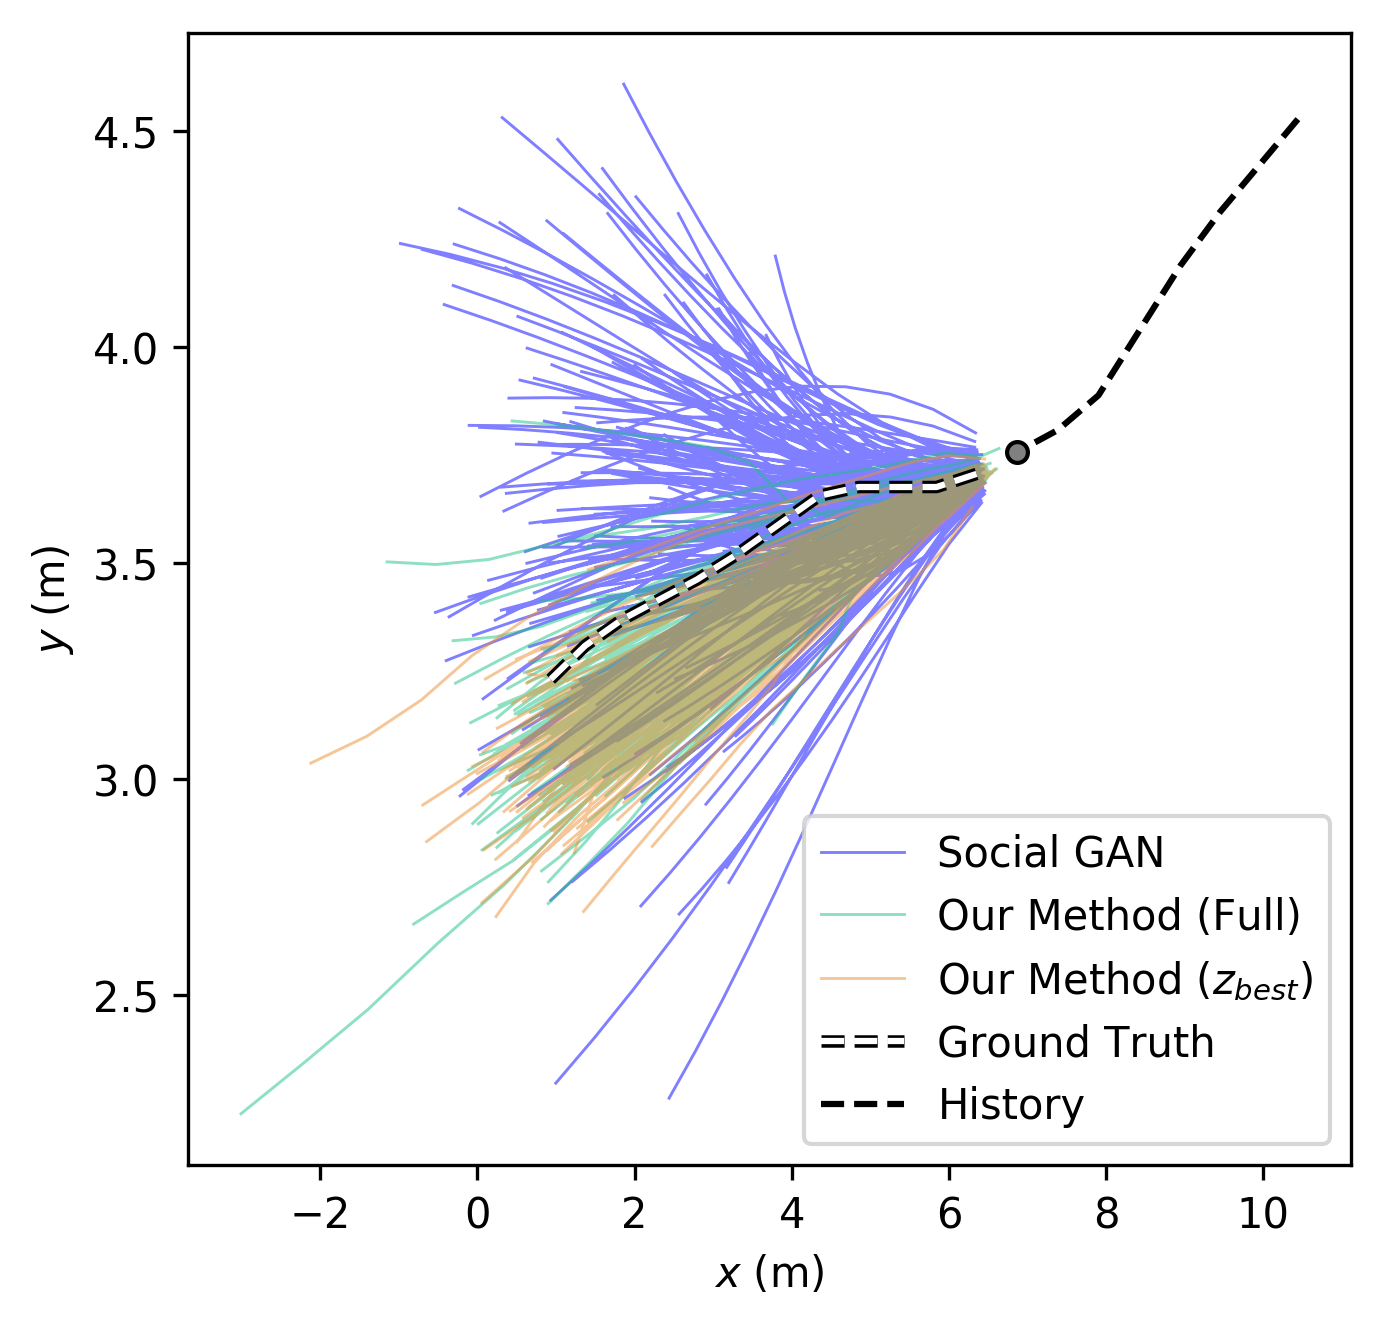

In [308]:
plot_run_trajs(data_precondition, dataset_name,
               our_preds_most_likely_list, our_preds_list,
               sgan_preds_list, sgan_gt_list, eval_inputs, eval_data_dict,
               data_ids, t_predicts, random_scene_idxs, num_runs,
               specific_agent=0)#, save_at='../sgan-dataset/plots/qualitative/closer_preds.pdf')
plt.show()

0 0 21


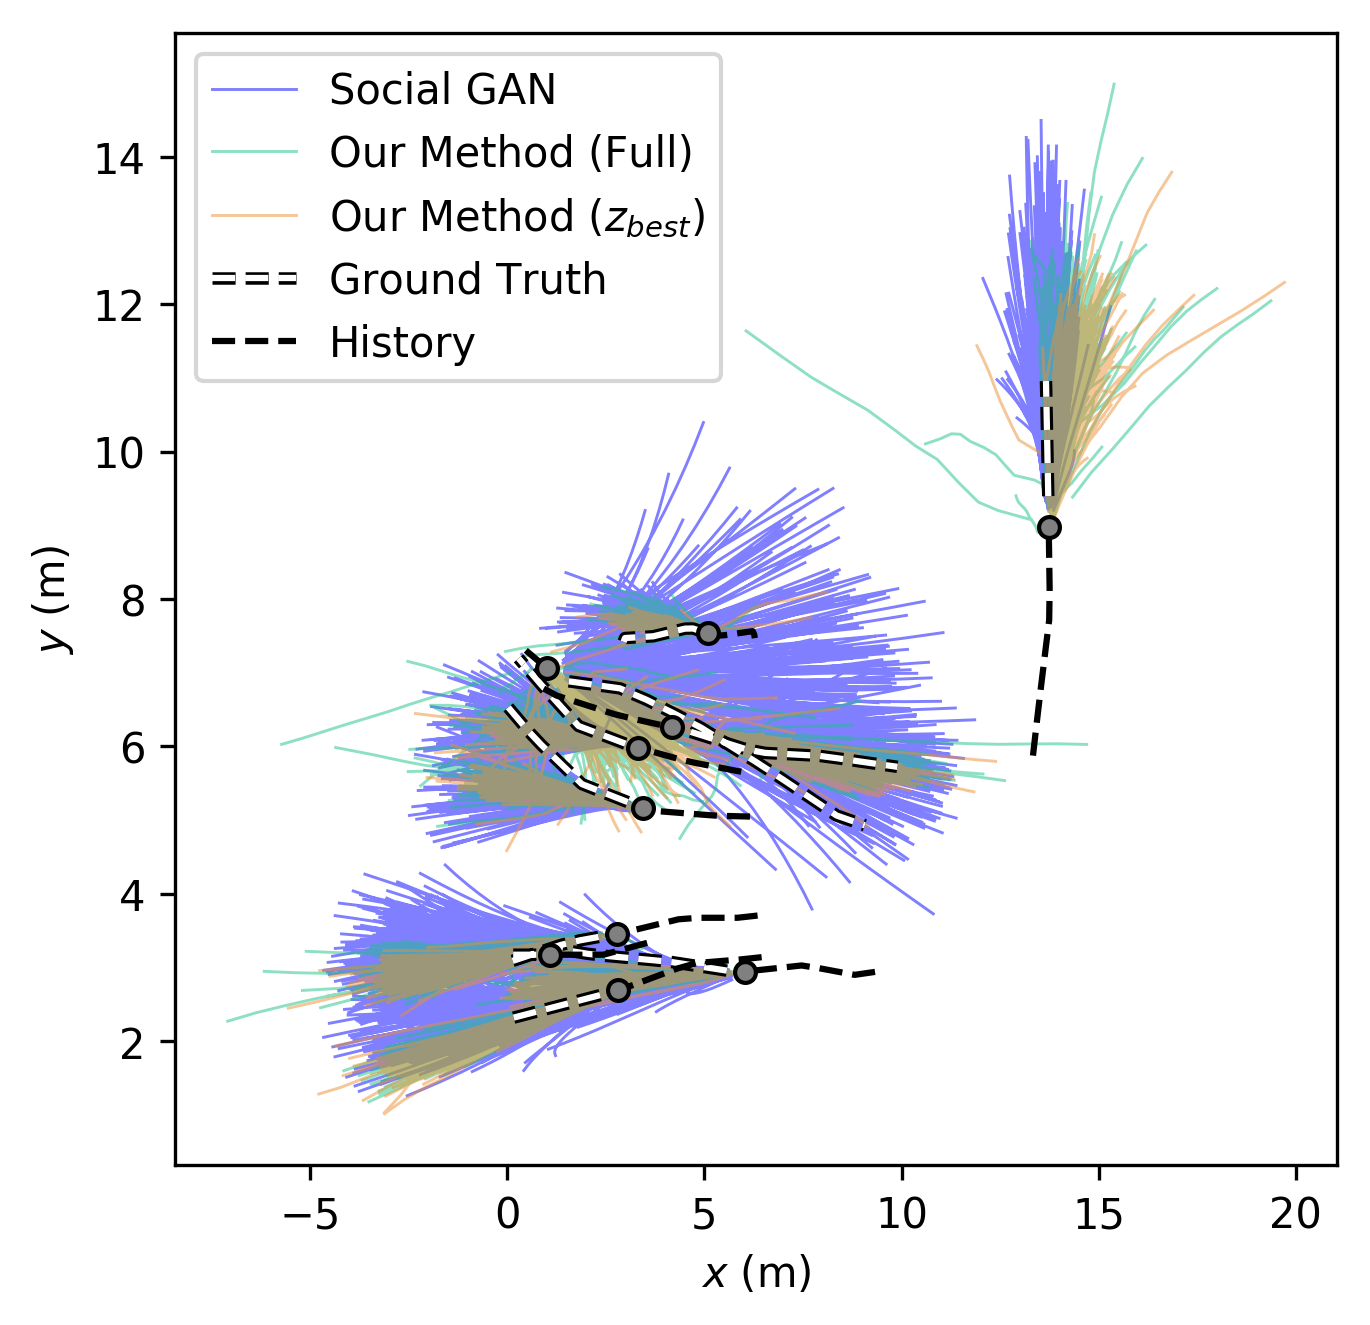

In [387]:
plot_run_trajs(data_precondition, dataset_name,
               our_preds_most_likely_list, our_preds_list,
               sgan_preds_list, sgan_gt_list, eval_inputs, eval_data_dict,
               data_ids, t_predicts, random_scene_idxs, num_runs,
               calc_vels=False)#, save_at='../sgan-dataset/plots/qualitative/closer_preds.pdf')

In [427]:
color_dict = defaultdict(dict)

0 0 18


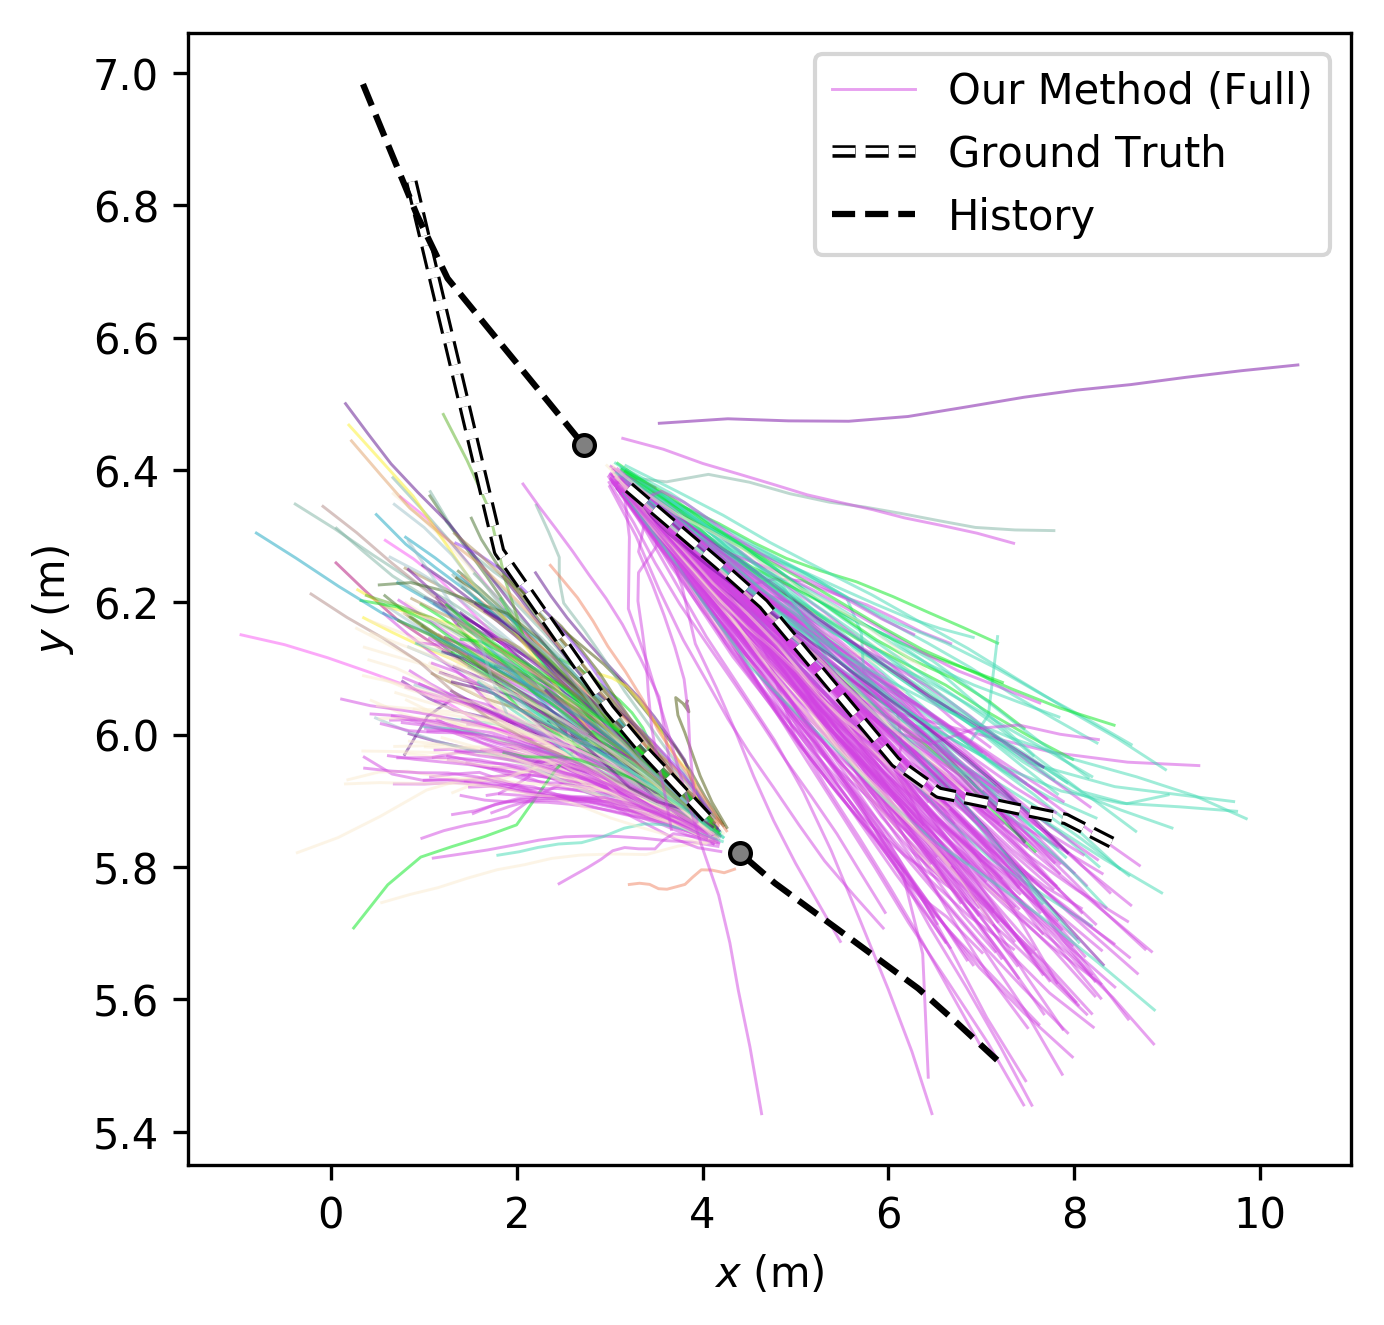

In [429]:
plot_run_trajs_with_z(data_precondition, dataset_name, color_dict,
                          our_preds_most_likely_list, our_preds_list, our_preds_z_list,
                          sgan_preds_list, sgan_gt_list, eval_inputs, eval_data_dict,
                          data_ids, t_predicts, random_scene_idxs, num_runs,
                          specific_agents=[8, 4], save_at='../sgan-dataset/plots/qualitative/z_value_colors_zara1.pdf')